In [1]:
%load_ext watermark
%watermark -a "D R Revanth Darshan 21BAI1055" -u -d -v -m

Author: D R Revanth Darshan 21BAI1055

Last updated: 2024-04-18

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 8.12.3

Compiler    : MSC v.1928 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : AMD64 Family 25 Model 80 Stepping 0, AuthenticAMD
CPU cores   : 16
Architecture: 64bit



Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.0078 - val_loss: 0.0011
Epoch 2/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0019 - val_loss: 9.0717e-04
Epoch 3/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.0011 - val_loss: 9.9621e-04
Epoch 4/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 5/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - loss: 0.0013 - val_loss: 7.3977e-04
Epoch 6/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - loss: 5.0230e-04 - val_loss: 7.4703e-04
Epoch 7/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 7.4955e-04 - val_loss: 7.4070e-04
Epoch 8/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 5.4062e-04 - val_loss: 7.9997e-04
Epoch 9/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - loss: 9.2296e-04 - val_loss: 7.4166e-04
Epoch 10/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 8.9796e-04 - val_loss: 7.5439e-04
Epoch 11/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 5.6979e-04 - val_loss: 7.9612e-04
Epoc

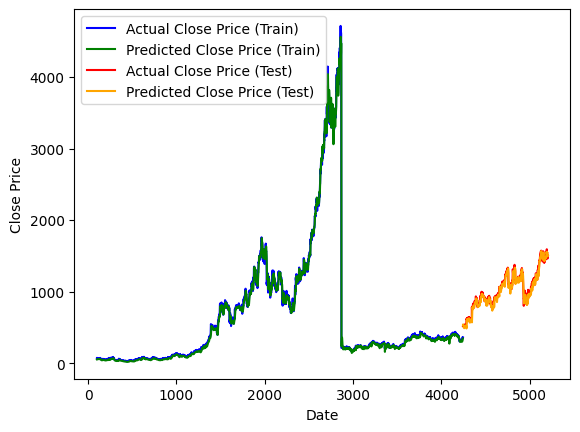

In [16]:
#multivariate time series
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the stock market data
data = pd.read_csv('/kaggle/input/nifty50-stock-market-data/TITAN.csv')

# Select relevant features
features = ['Open', 'High', 'Low', 'Close', 'Volume']
data = data[features]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split the data into train and test sets
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size], scaled_data[train_size:len(scaled_data)]

# Define function to create dataset
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset)-time_step-1):
        X.append(dataset[i:(i+time_step), :])
        Y.append(dataset[i + time_step, :])  # Using all features as the target variable
    return np.array(X), np.array(Y)

# Reshape into [samples, time steps, features]
time_step = 100
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, len(features))))
model.add(LSTM(units=50))
model.add(Dense(units=len(features)))  # Output layer with the same number of units as features
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=25, batch_size=64, verbose=1)

# Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
Y_train_inv = scaler.inverse_transform(Y_train)
Y_test_inv = scaler.inverse_transform(Y_test)

# Evaluate the model
train_mae = mean_absolute_error(Y_train_inv.flatten(), train_predict.flatten())
train_rmse = np.sqrt(mean_squared_error(Y_train_inv.flatten(), train_predict.flatten()))
train_mape = np.mean(np.abs((Y_train_inv.flatten() - train_predict.flatten()) / Y_train_inv.flatten())) * 100

test_mae = mean_absolute_error(Y_test_inv.flatten(), test_predict.flatten())
test_rmse = np.sqrt(mean_squared_error(Y_test_inv.flatten(), test_predict.flatten()))
test_mape = np.mean(np.abs((Y_test_inv.flatten() - test_predict.flatten()) / Y_test_inv.flatten())) * 100

print("Training MAE:", train_mae)
print("Training RMSE:", train_rmse)
print("Training MAPE:", train_mape)

print("Test MAE:", test_mae)
print("Test RMSE:", test_rmse)
print("Test MAPE:", test_mape)

# Plotting
plt.plot(data.index[time_step:time_step+len(train_predict)], Y_train_inv[:, 3], color='blue', label='Actual Close Price (Train)')
plt.plot(data.index[time_step:time_step+len(train_predict)], train_predict[:, 3], color='green', label='Predicted Close Price (Train)')
plt.plot(data.index[time_step+len(train_predict)+1:time_step+len(train_predict)+1+len(test_predict)], Y_test_inv[:, 3], color='red', label='Actual Close Price (Test)')
plt.plot(data.index[time_step+len(train_predict)+1:time_step+len(train_predict)+1+len(test_predict)], test_predict[:, 3], color='orange', label='Predicted Close Price (Test)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 0.0097 - val_loss: 1.4613e-04
Epoch 2/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 3/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 0.0013 - val_loss: 8.3466e-05
Epoch 4/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 9.6267e-04 - val_loss: 9.0024e-05
Epoch 5/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 4.9296e-04 - val_loss: 5.0921e-04
Epoch 6/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - loss: 5.7767e-04 - val_loss: 2.8089e-04
Epoch 7/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 6.4669e-04 - val_loss: 8.0851e-05
Epoch 8/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.0010 - val_loss: 5.9562e-05
Epoch 9/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 2.2756e-04 - val_loss: 2.2826e-04
Epoch 10/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - loss: 3.5684e-04 - val_loss: 8.2366e-05
Epoch 11/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 5.8329e-04 - val_loss: 

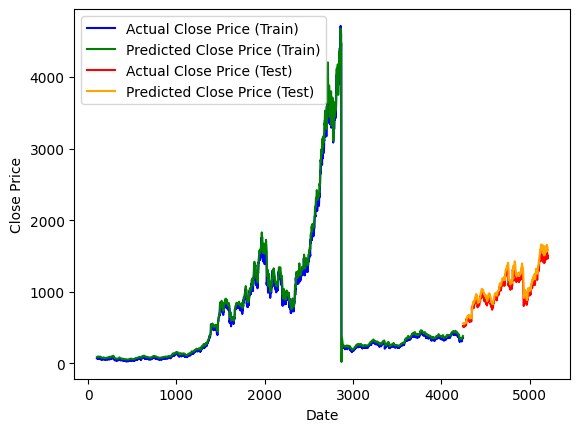

In [17]:
#univariate time series
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the stock market data
data = pd.read_csv('/kaggle/input/nifty50-stock-market-data/TITAN.csv')

# Select relevant feature (e.g., Close price)
data = data[['Close']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split the data into train and test sets
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size], scaled_data[train_size:len(scaled_data)]

# Define function to create dataset
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset)-time_step-1):
        X.append(dataset[i:(i+time_step), 0])
        Y.append(dataset[i + time_step, 0])  # Using 'Close' price as the target variable
    return np.array(X), np.array(Y)

# Reshape into [samples, time steps, features]
time_step = 100
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=25, batch_size=64, verbose=1)

# Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
Y_train_inv = scaler.inverse_transform([Y_train])
Y_test_inv = scaler.inverse_transform([Y_test])

# Evaluate the model
train_mae = mean_absolute_error(Y_train_inv[0], train_predict[:,0])
train_rmse = np.sqrt(mean_squared_error(Y_train_inv[0], train_predict[:,0]))
train_mape = np.mean(np.abs((Y_train_inv[0] - train_predict[:,0]) / Y_train_inv[0])) * 100

test_mae = mean_absolute_error(Y_test_inv[0], test_predict[:,0])
test_rmse = np.sqrt(mean_squared_error(Y_test_inv[0], test_predict[:,0]))
test_mape = np.mean(np.abs((Y_test_inv[0] - test_predict[:,0]) / Y_test_inv[0])) * 100

print("Training MAE:", train_mae)
print("Training RMSE:", train_rmse)
print("Training MAPE:", train_mape)

print("Test MAE:", test_mae)
print("Test RMSE:", test_rmse)
print("Test MAPE:", test_mape)

# Plotting
plt.plot(data.index[time_step:time_step+len(train_predict)], Y_train_inv[0], color='blue', label='Actual Close Price (Train)')
plt.plot(data.index[time_step:time_step+len(train_predict)], train_predict[:,0], color='green', label='Predicted Close Price (Train)')
plt.plot(data.index[time_step+len(train_predict)+1:time_step+len(train_predict)+1+len(test_predict)], Y_test_inv[0], color='red', label='Actual Close Price (Test)')
plt.plot(data.index[time_step+len(train_predict)+1:time_step+len(train_predict)+1+len(test_predict)], test_predict[:,0], color='orange', label='Predicted Close Price (Test)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0217
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0013
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0010
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 8.0550e-04
Epoch 5/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 5.7448e-04
Epoch 6/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 6.0541e-04
Epoch 7/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 3.9796e-04
Epoch 8/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 5.4328e-04
Epoch 9/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 3.4047e-04
Epoch 10/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 2.9142e-04
Epoch 11/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 3.7855e-04
Epoch 12/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 2.7198e-04
Epoch 13/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 3.1807e-04
Epoch 14/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 2.8976e-04
Epoch 15/25
66/66 ━━━━━━━━━━━━━━━━━━━━

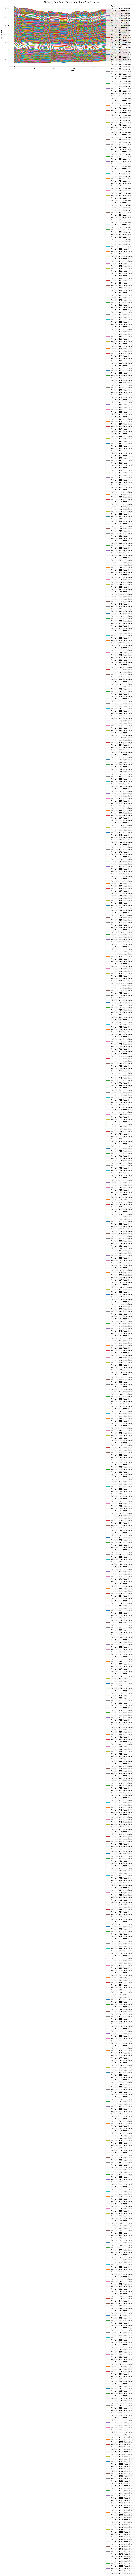

In [19]:
#Multistep Time Series
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load the stock market data
data = pd.read_csv('/kaggle/input/nifty50-stock-market-data/TITAN.csv')

# Select only the 'Close' price
data = data[['Close']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Function to create dataset with multiple time steps
def create_dataset(data, time_steps):
    X, Y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        Y.append(data[i+1:i+time_steps+1])  # Predicting the next time steps
    return np.array(X), np.array(Y)

# Define the number of time steps to consider for prediction
time_steps = 30

# Create the dataset
X, Y = create_dataset(scaled_data, time_steps)

# Split the data into train and test sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, 1)))
model.add(LSTM(units=50))
model.add(Dense(units=time_steps))  # Output layer predicts multiple future time steps
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, Y_train, epochs=25, batch_size=64, verbose=1)

# Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions
train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1)).reshape(-1, time_steps)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1)).reshape(-1, time_steps)
Y_train_inv = scaler.inverse_transform(Y_train.reshape(-1, 1)).reshape(-1, time_steps)
Y_test_inv = scaler.inverse_transform(Y_test.reshape(-1, 1)).reshape(-1, time_steps)

# Calculate RMSE for train and test predictions
train_rmse = np.sqrt(mean_squared_error(Y_train_inv, train_predict))
test_rmse = np.sqrt(mean_squared_error(Y_test_inv, test_predict))
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

# Plotting the results for the test set
plt.figure(figsize=(14, 7))
plt.plot(Y_test_inv[0], label='Actual')
for i in range(len(test_predict)):
    plt.plot(test_predict[i], label=f'Predicted {i+1} steps ahead')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()
plt.title('Multistep Time Series Forecasting - Stock Price Prediction')
plt.show()
